In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [01:59<00:00, 736.22it/s]


In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [25]:
final["UPDATEDTEXT"]=preprocessed_reviews

In [26]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [27]:
final.head()

Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   
70677  76870  B00002N8SM  A19Q006CSFT011           Arlielle   
70676  76869  B00002N8SM  A1FYH4S02BW7FN           wonderer   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV      eyeofthestorm   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   
70677                     0                       0      0  1288396800   
70676                     0                       0      0  1290038400   
70675                     0                       0      0  1306972800   

                                       Summary  \
22620                            made in china   
22621                        Dog Lover Delites   
70677                  only one fruitfly stuck   
70676  Doesn't work!! Don't waste your money!!   
70675                            A big rip off   

                                                    Text  \
22620  My dogs loves this chicken but its a product f...   
22621  Our dogs just love them.  I saw them in a pet ...   
70677  I had an infestation of fruitflies, they were ...   
70676  Worst product I have gotten in long time. Woul...   
70675  I wish I'd read the reviews before making this...   

                                             UPDATEDTEXT  
22620  dogs loves chicken product china wont buying a...  
22621  dogs love saw pet store tag attached regarding...  
70677  infestation fruitflies literally everywhere fl...  
70676  worst product gotten long time would rate no s...  
70675  wish would read reviews making purchase basica...

In [28]:
final['text_len'] = final['UPDATEDTEXT'].str.len()

In [29]:
final.head()

Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   
70677  76870  B00002N8SM  A19Q006CSFT011           Arlielle   
70676  76869  B00002N8SM  A1FYH4S02BW7FN           wonderer   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV      eyeofthestorm   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   
70677                     0                       0      0  1288396800   
70676                     0                       0      0  1290038400   
70675                     0                       0      0  1306972800   

                                       Summary  \
22620                            made in china   
22621                        Dog Lover Delites   
70677                  only one fruitfly stuck   
70676  Doesn't work!! Don't waste your money!!   
70675                            A big rip off   

                                                    Text  \
22620  My dogs loves this chicken but its a product f...   
22621  Our dogs just love them.  I saw them in a pet ...   
70677  I had an infestation of fruitflies, they were ...   
70676  Worst product I have gotten in long time. Woul...   
70675  I wish I'd read the reviews before making this...   

                                             UPDATEDTEXT  text_len  
22620  dogs loves chicken product china wont buying a...       162  
22621  dogs love saw pet store tag attached regarding...        72  
70677  infestation fruitflies literally everywhere fl...       406  
70676  worst product gotten long time would rate no s...       209  
70675  wish would read reviews making purchase basica...       277

In [30]:
df=pd.DataFrame(final)

In [31]:
df.head()

Id   ProductId          UserId        ProfileName  \
22620  24750  2734888454  A13ISQV0U9GZIC          Sandikaye   
22621  24751  2734888454  A1C298ITT645B6  Hugh G. Pritchard   
70677  76870  B00002N8SM  A19Q006CSFT011           Arlielle   
70676  76869  B00002N8SM  A1FYH4S02BW7FN           wonderer   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV      eyeofthestorm   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
22620                     1                       1      0  1192060800   
22621                     0                       0      1  1195948800   
70677                     0                       0      0  1288396800   
70676                     0                       0      0  1290038400   
70675                     0                       0      0  1306972800   

                                       Summary  \
22620                            made in china   
22621                        Dog Lover Delites   
70677                  only one fruitfly stuck   
70676  Doesn't work!! Don't waste your money!!   
70675                            A big rip off   

                                                    Text  \
22620  My dogs loves this chicken but its a product f...   
22621  Our dogs just love them.  I saw them in a pet ...   
70677  I had an infestation of fruitflies, they were ...   
70676  Worst product I have gotten in long time. Woul...   
70675  I wish I'd read the reviews before making this...   

                                             UPDATEDTEXT  text_len  
22620  dogs loves chicken product china wont buying a...       162  
22621  dogs love saw pet store tag attached regarding...        72  
70677  infestation fruitflies literally everywhere fl...       406  
70676  worst product gotten long time would rate no s...       209  
70675  wish would read reviews making purchase basica...       277

In [32]:
df.drop("Text",axis = 1, inplace = True)

In [33]:
df

Id   ProductId          UserId  \
22620  24750  2734888454  A13ISQV0U9GZIC   
22621  24751  2734888454  A1C298ITT645B6   
70677  76870  B00002N8SM  A19Q006CSFT011   
70676  76869  B00002N8SM  A1FYH4S02BW7FN   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV   
70673  76866  B00002N8SM  A3R3T5T1K8IN6P   
70672  76865  B00002N8SM  A11DU8T1ZXPRT7   
70671  76864  B00002N8SM   A71C9WY0242QU   
70670  76863  B00002N8SM   A17UIV0KM8JSV   
70669  76862  B00002N8SM   A5W8ZREO7C1WK   
70668  76861  B00002N8SM  A1J67DKGFR7TZ4   
70661  76853  B00002N8SM  A392XPUTJDHSDJ   
70667  76860  B00002N8SM   ASF1MKDA0N66O   
70666  76859  B00002N8SM   A88YOFJG6IPOZ   
70665  76858  B00002N8SM  A3B28AM0CWI7BJ   
70662  76854  B00002N8SM   A7E1DYOIQXM12   
70663  76855  B00002N8SM   A8XKSGA2EA6GJ   
70664  76857  B00002N8SM   AZKXR73X1CVIM   
70678  76871  B00002N8SM   AIW48SP4GCIOO   
70679  76872  B00002N8SM  A2B7IZJ243KWFX   
70674  76867  B00002N8SM  A1VSEBVZS81UCI   
70695  76890  B00002N8SM  A110QUC2ULFN7R   
70685  76879  B00002N8SM  A2579IQYG8Y9YF   
70680  76873  B00002N8SM   A1G98WP2G0CMC   
70684  76878  B00002N8SM  A1GQUBNRZK3RHI   
70683  76877  B00002N8SM  A1J4110YC5IFAB   
70687  76881  B00002N8SM  A1LU93B4XI1PZZ   
70688  76882  B00002N8SM  A32DW342WBJ6BX   
70689  76883  B00002N8SM  A29GWIJL72GXXZ   
70686  76880  B00002N8SM  A1S64UB4EOYFTK   
...      ...         ...             ...   
90976  98962  B009BSZWNC  A33NUVKG22QKRE   
56978  61808  B009C16ZP2  A22H0NAS6G66ZI   
82326  89529  B009CW5VUQ  A24P4U4CJL1SQ3   
82327  89530  B009CW5VUQ  A29O79B2LS1ZQ7   
82328  89531  B009CW5VUQ  A2YJ8Y9XVAG35C   
82329  89532  B009CW5VUQ  A3RFG4VH8KZXP3   
82330  89533  B009CW5VUQ   A7821UWSQ2OUP   
58909  63993  B009D54BCQ  A2BGLSHDRABS6X   
8141    8908  B009D668KS  A1YDQ8I5KVNF8P   
38862  42199  B009DR3GYI  A236IN6J0H7E2V   
38863  42200  B009DR3GYI   A1NBK07JEBCFI   
38864  42201  B009DR3GYI  A1ECIT3IBKPQCV   
38861  42198  B009DR3GYI    A8AOI6SNSGY6   
38865  42202  B009DR3GYI   A3HN9CXDWOYPQ   
49648  53915  B009EOLK0C  A3KQ5Q90X2ZCLV   
713      768  B009HINRX8  A2CAZG1CQ8BQI5   
712      766  B009HINRX8  A39BLB42U7M6BD   
711      765  B009HINRX8  A1OEL4UZT3KKI4   
710      764  B009HINRX8   ADDBLG0CFY9AI   
709      763  B009HINRX8  A3N9477PUE6WMR   
63441  68918  B009IAUEOU    AZFYU1OVBPZ3   
63440  68917  B009IAUEOU  A2DYHKORAISBPF   
36471  39644  B009KAQZ9G   A3UCO959VA9MV   
36470  39643  B009KAQZ9G  A3D9NUCR4RXDPY   
36469  39642  B009KAQZ9G  A20NB4UBW4WDKG   
34007  37008  B009KOHGEK  A36WGHR8TO5DKT   
65569  71232  B009KUFALA  A14WG4I5A1ZE8F   
35419  38512  B009O7B1I0  A2YWHBF45M64S2   
1362    1478  B009UOFU20   AJVB004EB0MVK   
5259    5703  B009WSNWC4   AMP7K1O84DH1T   

                                       ProfileName  HelpfulnessNumerator  \
22620                                    Sandikaye                     1   
22621                            Hugh G. Pritchard                     0   
70677                                     Arlielle                     0   
70676                                     wonderer                     0   
70675                                eyeofthestorm                     0   
70673                          LILIAN J. DE CIAFFI                     0   
70672                                     Zoggdogg                     0   
70671                                       MeMeMe                     0   
70670                                     S. Cohen                     0   
70669                                     Mireille                     0   
70668                                       ek8650                     0   
70661                                     T. Chang                     3   
70667                        M. Dawson "flymaster"                     0   
70666                                        duane                     0   
70665                                BB in LA "BB"                     0   
70662                                   Hetal Rana               

In [34]:
Y1=df["Score"].values

In [35]:
df.drop("Score",axis = 1, inplace = True)

In [36]:
df

Id   ProductId          UserId  \
22620  24750  2734888454  A13ISQV0U9GZIC   
22621  24751  2734888454  A1C298ITT645B6   
70677  76870  B00002N8SM  A19Q006CSFT011   
70676  76869  B00002N8SM  A1FYH4S02BW7FN   
70675  76868  B00002N8SM   AUE8TB5VHS6ZV   
70673  76866  B00002N8SM  A3R3T5T1K8IN6P   
70672  76865  B00002N8SM  A11DU8T1ZXPRT7   
70671  76864  B00002N8SM   A71C9WY0242QU   
70670  76863  B00002N8SM   A17UIV0KM8JSV   
70669  76862  B00002N8SM   A5W8ZREO7C1WK   
70668  76861  B00002N8SM  A1J67DKGFR7TZ4   
70661  76853  B00002N8SM  A392XPUTJDHSDJ   
70667  76860  B00002N8SM   ASF1MKDA0N66O   
70666  76859  B00002N8SM   A88YOFJG6IPOZ   
70665  76858  B00002N8SM  A3B28AM0CWI7BJ   
70662  76854  B00002N8SM   A7E1DYOIQXM12   
70663  76855  B00002N8SM   A8XKSGA2EA6GJ   
70664  76857  B00002N8SM   AZKXR73X1CVIM   
70678  76871  B00002N8SM   AIW48SP4GCIOO   
70679  76872  B00002N8SM  A2B7IZJ243KWFX   
70674  76867  B00002N8SM  A1VSEBVZS81UCI   
70695  76890  B00002N8SM  A110QUC2ULFN7R   
70685  76879  B00002N8SM  A2579IQYG8Y9YF   
70680  76873  B00002N8SM   A1G98WP2G0CMC   
70684  76878  B00002N8SM  A1GQUBNRZK3RHI   
70683  76877  B00002N8SM  A1J4110YC5IFAB   
70687  76881  B00002N8SM  A1LU93B4XI1PZZ   
70688  76882  B00002N8SM  A32DW342WBJ6BX   
70689  76883  B00002N8SM  A29GWIJL72GXXZ   
70686  76880  B00002N8SM  A1S64UB4EOYFTK   
...      ...         ...             ...   
90976  98962  B009BSZWNC  A33NUVKG22QKRE   
56978  61808  B009C16ZP2  A22H0NAS6G66ZI   
82326  89529  B009CW5VUQ  A24P4U4CJL1SQ3   
82327  89530  B009CW5VUQ  A29O79B2LS1ZQ7   
82328  89531  B009CW5VUQ  A2YJ8Y9XVAG35C   
82329  89532  B009CW5VUQ  A3RFG4VH8KZXP3   
82330  89533  B009CW5VUQ   A7821UWSQ2OUP   
58909  63993  B009D54BCQ  A2BGLSHDRABS6X   
8141    8908  B009D668KS  A1YDQ8I5KVNF8P   
38862  42199  B009DR3GYI  A236IN6J0H7E2V   
38863  42200  B009DR3GYI   A1NBK07JEBCFI   
38864  42201  B009DR3GYI  A1ECIT3IBKPQCV   
38861  42198  B009DR3GYI    A8AOI6SNSGY6   
38865  42202  B009DR3GYI   A3HN9CXDWOYPQ   
49648  53915  B009EOLK0C  A3KQ5Q90X2ZCLV   
713      768  B009HINRX8  A2CAZG1CQ8BQI5   
712      766  B009HINRX8  A39BLB42U7M6BD   
711      765  B009HINRX8  A1OEL4UZT3KKI4   
710      764  B009HINRX8   ADDBLG0CFY9AI   
709      763  B009HINRX8  A3N9477PUE6WMR   
63441  68918  B009IAUEOU    AZFYU1OVBPZ3   
63440  68917  B009IAUEOU  A2DYHKORAISBPF   
36471  39644  B009KAQZ9G   A3UCO959VA9MV   
36470  39643  B009KAQZ9G  A3D9NUCR4RXDPY   
36469  39642  B009KAQZ9G  A20NB4UBW4WDKG   
34007  37008  B009KOHGEK  A36WGHR8TO5DKT   
65569  71232  B009KUFALA  A14WG4I5A1ZE8F   
35419  38512  B009O7B1I0  A2YWHBF45M64S2   
1362    1478  B009UOFU20   AJVB004EB0MVK   
5259    5703  B009WSNWC4   AMP7K1O84DH1T   

                                       ProfileName  HelpfulnessNumerator  \
22620                                    Sandikaye                     1   
22621                            Hugh G. Pritchard                     0   
70677                                     Arlielle                     0   
70676                                     wonderer                     0   
70675                                eyeofthestorm                     0   
70673                          LILIAN J. DE CIAFFI                     0   
70672                                     Zoggdogg                     0   
70671                                       MeMeMe                     0   
70670                                     S. Cohen                     0   
70669                                     Mireille                     0   
70668                                       ek8650                     0   
70661                                     T. Chang                     3   
70667                        M. Dawson "flymaster"                     0   
70666                                        duane                     0   
70665                                BB in LA "BB"                     0   
70662                                   Hetal Rana               

In [37]:
df1=df.drop(df.columns[[0,1,2,3,4,5,6,7]],axis=1)

In [38]:
df1.head()

UPDATEDTEXT  text_len
22620  dogs loves chicken product china wont buying a...       162
22621  dogs love saw pet store tag attached regarding...        72
70677  infestation fruitflies literally everywhere fl...       406
70676  worst product gotten long time would rate no s...       209
70675  wish would read reviews making purchase basica...       277

In [39]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(df1, Y1, test_size=0.3, shuffle=False)
#X1_train, X1_cv, Y1_train, Y1_cv = train_test_split(X1_train, Y1_train, test_size=0.2,shuffle=False)

In [40]:
print(X1_train.shape, Y1_train.shape)
#print(X1_cv.shape, Y1_cv.shape)
print(X1_test.shape, Y1_test.shape)

(61441, 2) (61441,)
(26332, 2) (26332,)


In [41]:
X1_train["UPDATEDTEXT"]

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
70673    happy item many flies disturbing kitchen put p...
70672    thing item trapped fruit flies not work fly tr...
70671    nurturing plant work well decided repot larger...
70670    placed around house several days setup fly att...
70669    please not waste money fly trap absolutely use...
70668    let put way flies stay traps left looks like s...
70661    not know product performs big flies sucks frui...
70667    flies buzz around thing like not even many fli...
70666    horrible product first item not work week lots...
70665    never caught even one fly got inside left week...
70662    ineffective worthless bought product indoors t...
70663    problem lot fruit flies kitchen picked one tak.

# [1] K-MEANS Clustering :

## BOW :

In [42]:
count_vect = CountVectorizer(min_df=10,ngram_range=(1,2))
X_train_BOW = count_vect.fit_transform(X1_train["UPDATEDTEXT"])
X_train_BOW.shape

(61441, 36016)

In [43]:
X_test_BOW = count_vect.transform(X1_test["UPDATEDTEXT"])
X_test_BOW.shape

(26332, 36016)

In [45]:
from sklearn.cluster import KMeans
inertia =[]
mylist = list(range(2,10,2))
for i in tqdm(mylist):
    kmeans = KMeans(n_clusters=i,n_jobs=-1)
    kmeans.fit(X_train_BOW)
    error=kmeans.inertia_
    inertia.append(error)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [56:19<00:00, 855.81s/it]


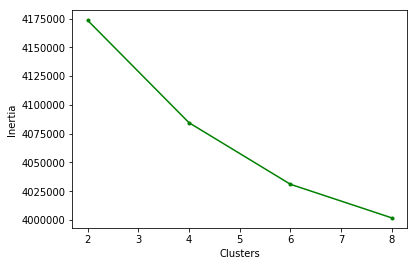

In [181]:
plt.figure()
plt.plot(mylist, inertia, color='green',marker = '.')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

In [182]:
kmeans1 = KMeans(n_clusters=6, n_jobs=-1)
kmeans1.fit(X_train_BOW)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [183]:
X1_train['cluster_BOW']=kmeans1.labels_
B=pd.concat([X1_train[['UPDATEDTEXT','cluster_BOW']]])
B.head(5)

UPDATEDTEXT  cluster_BOW
22620  dogs loves chicken product china wont buying a...            3
22621  dogs love saw pet store tag attached regarding...            3
70677  infestation fruitflies literally everywhere fl...            3
70676  worst product gotten long time would rate no s...            3
70675  wish would read reviews making purchase basica...            3

In [184]:
b0=B[B['cluster_BOW']==0]
b0.head(5)

UPDATEDTEXT  cluster_BOW
47158  tea delicious flavorful aroma inviting not rea...            0
61803  ashby japanese green tea distinctive strong gr...            0
49918  received wild huckleberry tea tin gift enjoyed...            0
49919  tea wonderful purchased town years back unfort...            0
79433  known tea flavoring would not ordered get sick...            0

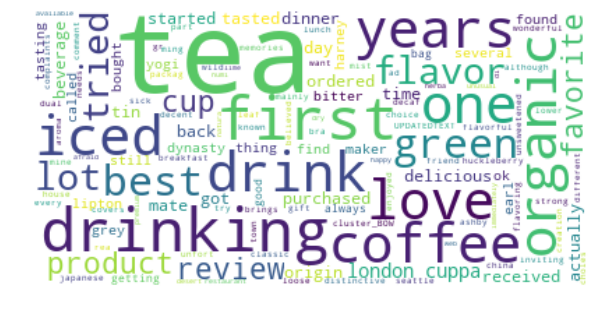

In [185]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(b0))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [186]:
b1=B[B['cluster_BOW']==1]
b1.head(5)

UPDATEDTEXT  cluster_BOW
5895   years old care cats entire life presently four...            1
5840   cat loves fancy feast cat food variety pack pa...            1
46636  cat loves fancy feast cat food variety pack pa...            1
18024  used fan canidae recent vet bills sick dog fou...            1
18038  bought food adult male chiweenie two female ch...            1

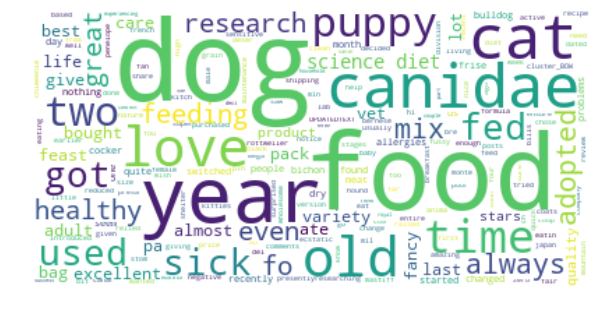

In [187]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(b1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [188]:
b2=B[B['cluster_BOW']==2]
b2.head(5)

UPDATEDTEXT  cluster_BOW
79234  ordered jack russell got stegosaurus toy far h...            2
79297  purchased stegosaurus local pet store day adop...            2
79303  number nylabones natural color years old dog d...            2
79323  could never give dog anything cloth like soft ...            2
46638  stuff really nice around special treat cat wou...            2

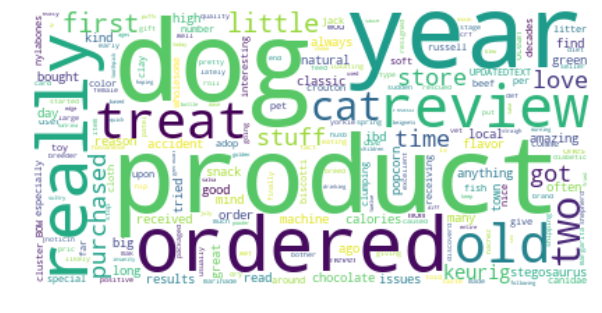

In [189]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(b2))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [190]:
b3=B[B['cluster_BOW']==3]
b3.head(5)

UPDATEDTEXT  cluster_BOW
22620  dogs loves chicken product china wont buying a...            3
22621  dogs love saw pet store tag attached regarding...            3
70677  infestation fruitflies literally everywhere fl...            3
70676  worst product gotten long time would rate no s...            3
70675  wish would read reviews making purchase basica...            3

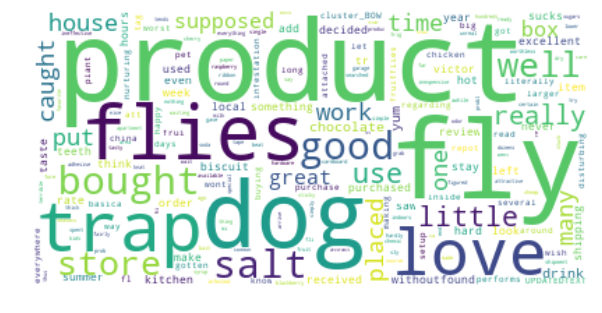

In [191]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(b3))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [192]:
b4=B[B['cluster_BOW']==4]
b4.head(5)

UPDATEDTEXT  cluster_BOW
48736  one favorite places frequent afford nice meal ...            4
48731  trying find individual pack option affordable ...            4
38888  blend one starbucks gentler blends like taste ...            4
48547  love prefer coffee chicory adds mellowness low...            4
58957  not normally fan flavored coffees one enjoyed ...            4

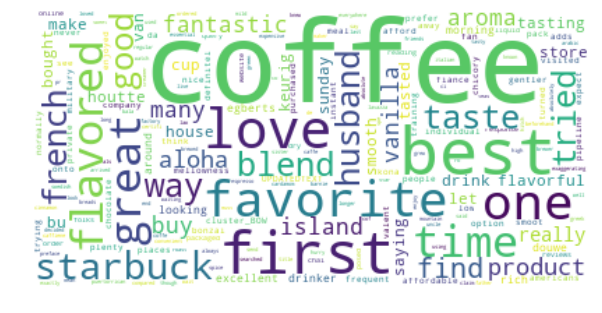

In [193]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(b4))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [194]:
b5=B[B['cluster_BOW']==5]
b5.head(5)

UPDATEDTEXT  cluster_BOW
70672  thing item trapped fruit flies not work fly tr...            5
70669  please not waste money fly trap absolutely use...            5
70667  flies buzz around thing like not even many fli...            5
70666  horrible product first item not work week lots...            5
70663  problem lot fruit flies kitchen picked one tak...            5

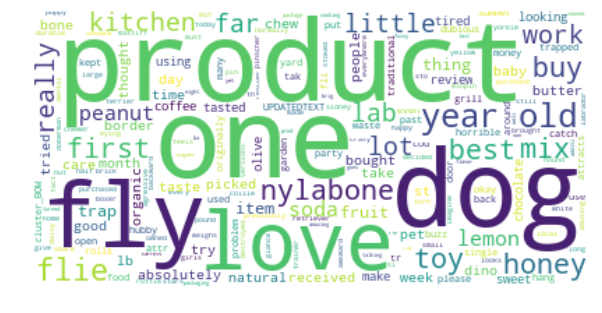

In [195]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(b5))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


## TFIDF :

In [80]:
tf_idf_vect = TfidfVectorizer(min_df = 10, ngram_range = (1,2))
tf_idf_vect.fit(X1_train["UPDATEDTEXT"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X1_train_tfidf = tf_idf_vect.transform(X1_train["UPDATEDTEXT"])
print("the type of count vectorizer ",type(X1_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X1_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X1_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36016)
the number of unique words including both unigrams and bigrams  36016


In [81]:
X1_test_tfidf=tf_idf_vect.transform(X1_test["UPDATEDTEXT"])
X1_test_tfidf.shape

(26332, 36016)

In [82]:
from sklearn.cluster import KMeans
inertia1 =[]
mylist = list(range(2,10,2))
for i in tqdm(mylist):
    kmeansT = KMeans(n_clusters=i,n_jobs=-1)
    kmeansT.fit(X1_train_tfidf)
    error1=kmeansT.inertia_
    inertia1.append(error1)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:33:06<00:00, 1297.04s/it]


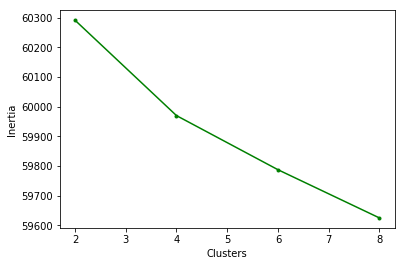

In [83]:
plt.figure()
plt.plot(mylist, inertia1, color='green',marker = '.')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

In [84]:
kmeans2 = KMeans(n_clusters=6, n_jobs=-1)
kmeans2.fit(X1_train_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [154]:
X1_train['cluster_tfidf']=kmeans2.labels_
S=pd.concat([X1_train[['UPDATEDTEXT','cluster_tfidf']]])
S.head(5)

UPDATEDTEXT  cluster_tfidf
22620  dogs loves chicken product china wont buying a...              1
22621  dogs love saw pet store tag attached regarding...              1
70677  infestation fruitflies literally everywhere fl...              4
70676  worst product gotten long time would rate no s...              4
70675  wish would read reviews making purchase basica...              4

In [155]:
s0=S[S['cluster_tfidf']==0]
s0.head(5)

UPDATEDTEXT  cluster_tfidf
34951  love sunflower seeds chocolate cherries imagin...              0
17792  bought gift valentine day girlfriend pleased c...              0
17793  high quality chocolate packaged gorgeous long ...              0
38459  not care good chocolate shipping candy bar tot...              0
38458  used favorite dark chocolate discovered dark h...              0

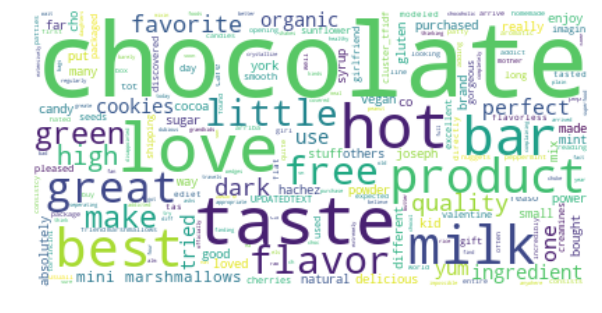

In [156]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(s0))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [157]:
s1=S[S['cluster_tfidf']==1]
s1.head(5)

UPDATEDTEXT  cluster_tfidf
22620  dogs loves chicken product china wont buying a...              1
22621  dogs love saw pet store tag attached regarding...              1
79267  dog loves things hes moderate chewer takes wee...              1
79347  great toy dogs chew everything else little che...              1
79265  originally purchased one puppy brought home si...              1

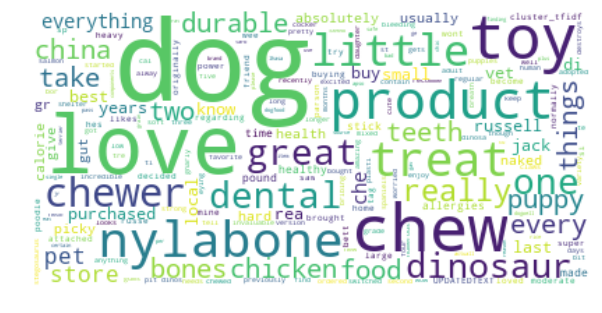

In [158]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(s1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [159]:
s2=S[S['cluster_tfidf']==2]
s2.head(5)

UPDATEDTEXT  cluster_tfidf
48736  one favorite places frequent afford nice meal ...              2
48731  trying find individual pack option affordable ...              2
38889  grocery store kinds gourmet coffees laid one t...              2
38888  blend one starbucks gentler blends like taste ...              2
48547  love prefer coffee chicory adds mellowness low...              2

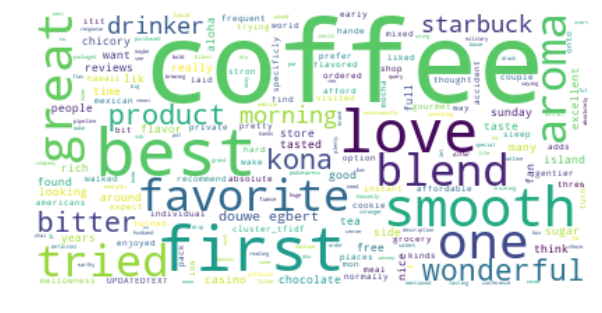

In [160]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(s2))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [161]:
s3=S[S['cluster_tfidf']==3]
s3.head(5)

UPDATEDTEXT  cluster_tfidf
8695   good flavor unique teas tried tea effective cl...              3
5630   daughter loved little tin came adagio tea set ...              3
5631   hooked wonderful highly recommended taste flav...              3
5632   normally hate hate hate citrus anything tea al...              3
94665  far one best teas ever someone often attends h...              3

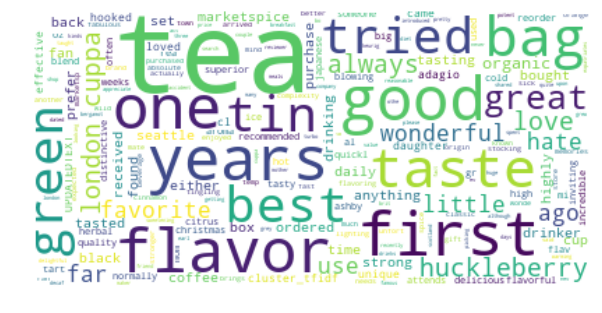

In [162]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(s3))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [163]:
s4=S[S['cluster_tfidf']==4]
s4.head(5)

UPDATEDTEXT  cluster_tfidf
70677  infestation fruitflies literally everywhere fl...              4
70676  worst product gotten long time would rate no s...              4
70675  wish would read reviews making purchase basica...              4
70673  happy item many flies disturbing kitchen put p...              4
70672  thing item trapped fruit flies not work fly tr...              4

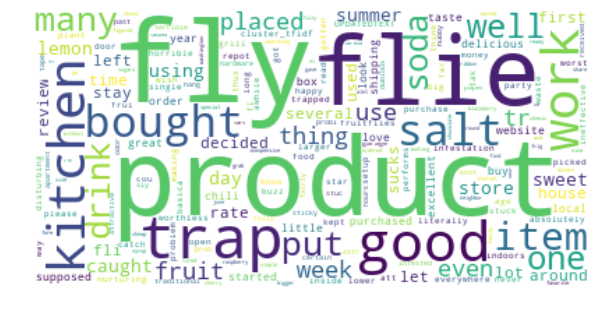

In [164]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(s4))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [165]:
s5=S[S['cluster_tfidf']==5]
s5.head(5)

UPDATEDTEXT  cluster_tfidf
2941  using food months find excellent fact two dogs...              5
1071  nine cats crazy kibbles last thing want cat fo...              5
5905  cat third favorite food great stuff gravy thic...              5
5907  one great basic food whatever cats really go m...              5
5895  years old care cats entire life presently four...              5

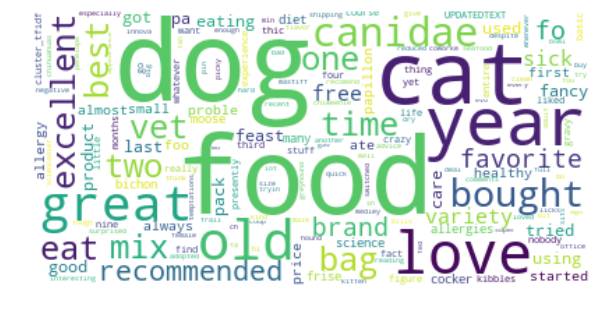

In [166]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(s5))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


## AVG W2V :

In [102]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X1_train["UPDATEDTEXT"]:
    list_of_sentance_train.append(sentance.split())

In [103]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X1_test["UPDATEDTEXT"]:
    list_of_sentance_test.append(sentance.split())

In [104]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('fantastic', 0.831275224685669), ('awesome', 0.8299395442008972), ('good', 0.8260673880577087), ('terrific', 0.8246525526046753), ('excellent', 0.7751930952072144), ('perfect', 0.7676709890365601), ('amazing', 0.7638097405433655), ('wonderful', 0.7418708801269531), ('fabulous', 0.70340895652771), ('incredible', 0.6911793351173401)]
[('tastiest', 0.7423896193504333), ('best', 0.7086427211761475), ('greatest', 0.702569842338562), ('softest', 0.6660753488540649), ('closest', 0.6574192047119141), ('awful', 0.6374907493591309), ('ive', 0.6364177465438843), ('sweetest', 0.6348121762275696), ('experienced', 0.6176437139511108), ('smoothest', 0.6114531755447388)]


In [105]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14706
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


In [107]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [04:41<00:00, 217.92it/s]


61441
50


In [108]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [02:05<00:00, 209.17it/s]


26332
50


In [312]:
from sklearn.cluster import KMeans
inertia2 =[]
mylist = list(range(2,10))
for i in tqdm(mylist):
    kmeansA = KMeans(n_clusters=i,n_jobs=-1)
    kmeansA.fit(sent_vectors_train)
    error2=kmeansA.inertia_
    inertia2.append(error2)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:28<00:00, 23.17s/it]


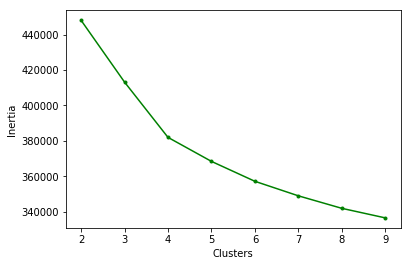

In [313]:
plt.figure()
plt.plot(mylist, inertia2, color='green',marker = '.')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

In [341]:
kmeans3 = KMeans(n_clusters=6, n_jobs=-1)
kmeans3.fit(sent_vectors_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [342]:
X1_train['cluster_AVGW2V']=kmeans3.labels_
A=pd.concat([X1_train[['UPDATEDTEXT','cluster_AVGW2V']]])
A.head(5)

UPDATEDTEXT  cluster_AVGW2V
22620  dogs loves chicken product china wont buying a...               4
22621  dogs love saw pet store tag attached regarding...               4
70677  infestation fruitflies literally everywhere fl...               3
70676  worst product gotten long time would rate no s...               3
70675  wish would read reviews making purchase basica...               3

In [343]:
a0=A[A['cluster_AVGW2V']==0]
a0.head(5)

UPDATEDTEXT  cluster_AVGW2V
70689  bought local hardware store terrible fly probl...               0
48731  trying find individual pack option affordable ...               0
79250  always pleased use amazon order various items ...               0
79365  ordered naylabone strong chewer holding pretty...               0
79293  impression got buying dinos received one not g...               0

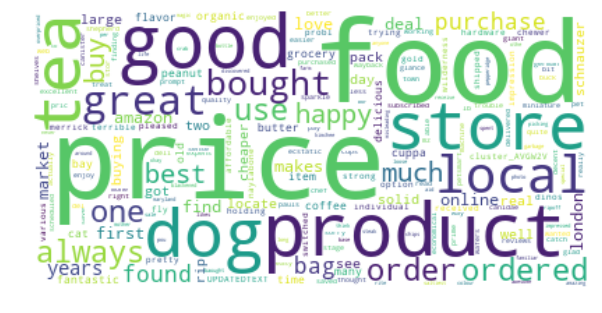

In [344]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(a0))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [345]:
a1=A[A['cluster_AVGW2V']==1]
a1.head(5)

UPDATEDTEXT  cluster_AVGW2V
17071  yes tasted taste like chemicals guess expect j...               1
28085  tennis player hubby mine got pack rack opel co...               1
28087  love stuff sugar free not rot gums tastes good...               1
88152  frosting great especially want use black not w...               1
47190  tasty tea almost like snack eat bag smooth not...               1

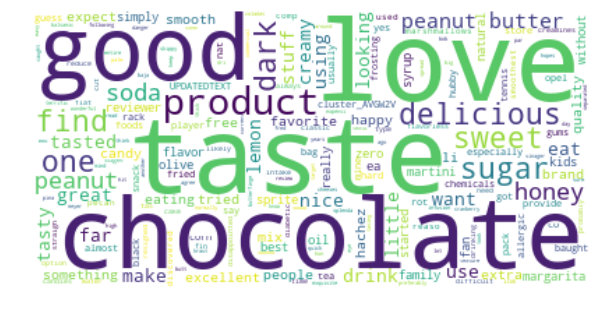

In [346]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(a1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [347]:
a2=A[A['cluster_AVGW2V']==2]
a2.head(5)

UPDATEDTEXT  cluster_AVGW2V
8694   new product need careful dosage strong batches...               2
8695   good flavor unique teas tried tea effective cl...               2
38889  grocery store kinds gourmet coffees laid one t...               2
38888  blend one starbucks gentler blends like taste ...               2
5630   daughter loved little tin came adagio tea set ...               2

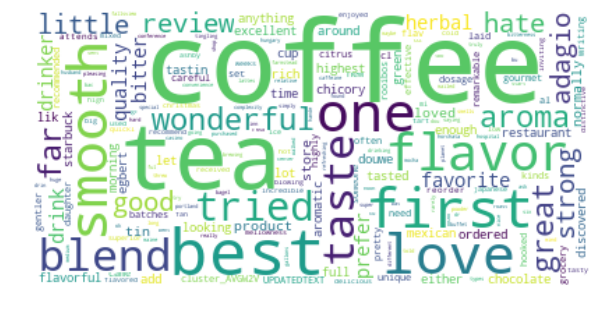

In [348]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(a2))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [349]:
a3=A[A['cluster_AVGW2V']==3]
a3.head(5)

UPDATEDTEXT  cluster_AVGW2V
70677  infestation fruitflies literally everywhere fl...               3
70676  worst product gotten long time would rate no s...               3
70675  wish would read reviews making purchase basica...               3
70673  happy item many flies disturbing kitchen put p...               3
70672  thing item trapped fruit flies not work fly tr...               3

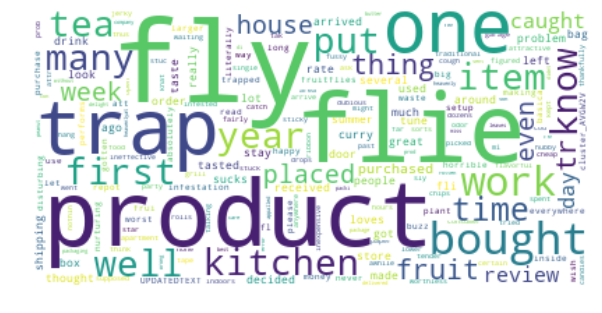

In [350]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(a3))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [351]:
a4=A[A['cluster_AVGW2V']==4]
a4.head(5)

UPDATEDTEXT  cluster_AVGW2V
22620  dogs loves chicken product china wont buying a...               4
22621  dogs love saw pet store tag attached regarding...               4
2942   glad cocker standard poodle puppy loves stuff ...               4
2941   using food months find excellent fact two dogs...               4
1071   nine cats crazy kibbles last thing want cat fo...               4

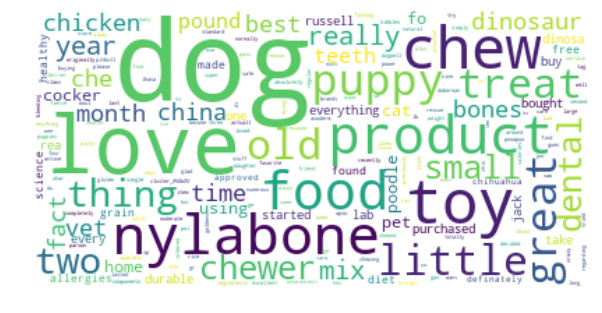

In [352]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(a4))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [353]:
a5=A[A['cluster_AVGW2V']==5]
a5.head(5)

UPDATEDTEXT  cluster_AVGW2V
5906   another favorite house cat not want times mont...               5
5841   fancy feast variety packs contain twenty four ...               5
67172  great product always kmr premixed liquid pop t...               5
29901  used decor ginger bread kids actually picked b...               5
88154  hate making black icing home always taste food...               5

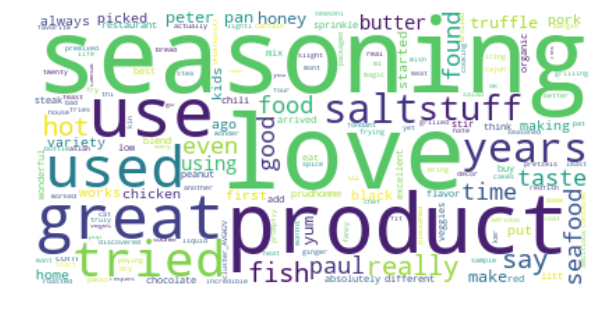

In [354]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(a5))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


## TFIDF weighted W2V :

In [212]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X1_train["UPDATEDTEXT"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [213]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1  

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [46:07<00:00, 22.20it/s]


In [214]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [20:39<00:00, 21.24it/s]


In [243]:
from sklearn.cluster import KMeans
inertia3 =[]
mylist = list(range(2,10))
for i in tqdm(mylist):
    kmeansW = KMeans(n_clusters=i,n_jobs=-1)
    kmeansW.fit(tfidf_sent_vectors_train)
    error3=kmeansW.inertia_
    inertia3.append(error3)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:16<00:00, 22.89s/it]


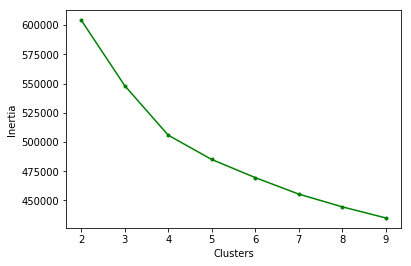

In [244]:
plt.figure()
plt.plot(mylist, inertia3, color='green',marker = '.')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

In [300]:
kmeans4 = KMeans(n_clusters=5, n_jobs=-1)
kmeans4.fit(tfidf_sent_vectors_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [301]:
X1_train['cluster_tfw2v']=kmeans4.labels_
TW=pd.concat([X1_train[['UPDATEDTEXT','cluster_tfw2v']]])
TW.head(5)

UPDATEDTEXT  cluster_tfw2v
22620  dogs loves chicken product china wont buying a...              2
22621  dogs love saw pet store tag attached regarding...              2
70677  infestation fruitflies literally everywhere fl...              1
70676  worst product gotten long time would rate no s...              1
70675  wish would read reviews making purchase basica...              1

In [302]:
tw0=TW[TW['cluster_tfw2v']==0]
tw0.head(5)

UPDATEDTEXT  cluster_tfw2v
17071  yes tasted taste like chemicals guess expect j...              0
28085  tennis player hubby mine got pack rack opel co...              0
28087  love stuff sugar free not rot gums tastes good...              0
88152  frosting great especially want use black not w...              0
26027  pretty remarkable writing review rooibos not p...              0

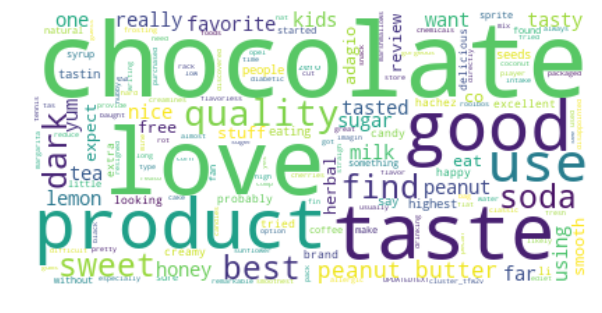

In [303]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(tw0))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [304]:
tw1=TW[TW['cluster_tfw2v']==1]
tw1.head(5)

UPDATEDTEXT  cluster_tfw2v
70677  infestation fruitflies literally everywhere fl...              1
70676  worst product gotten long time would rate no s...              1
70675  wish would read reviews making purchase basica...              1
70673  happy item many flies disturbing kitchen put p...              1
70672  thing item trapped fruit flies not work fly tr...              1

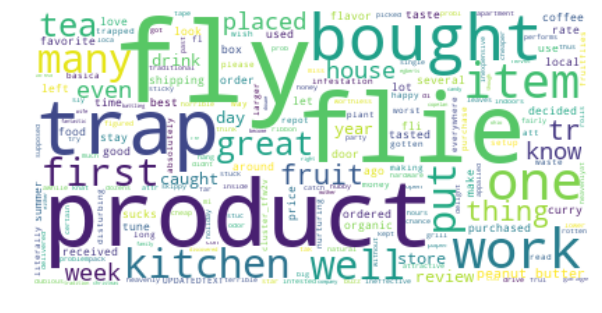

In [305]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(tw1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [306]:
tw2=TW[TW['cluster_tfw2v']==2]
tw2.head(5)

UPDATEDTEXT  cluster_tfw2v
22620  dogs loves chicken product china wont buying a...              2
22621  dogs love saw pet store tag attached regarding...              2
2942   glad cocker standard poodle puppy loves stuff ...              2
2941   using food months find excellent fact two dogs...              2
1071   nine cats crazy kibbles last thing want cat fo...              2

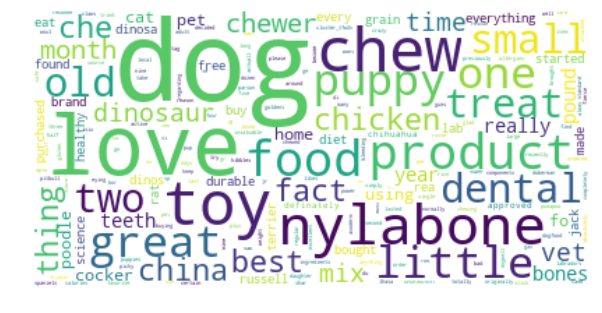

In [307]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(tw2))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [308]:
tw3=TW[TW['cluster_tfw2v']==3]
tw3.head(5)

UPDATEDTEXT  cluster_tfw2v
8695   good flavor unique teas tried tea effective cl...              3
48736  one favorite places frequent afford nice meal ...              3
48731  trying find individual pack option affordable ...              3
38889  grocery store kinds gourmet coffees laid one t...              3
38888  blend one starbucks gentler blends like taste ...              3

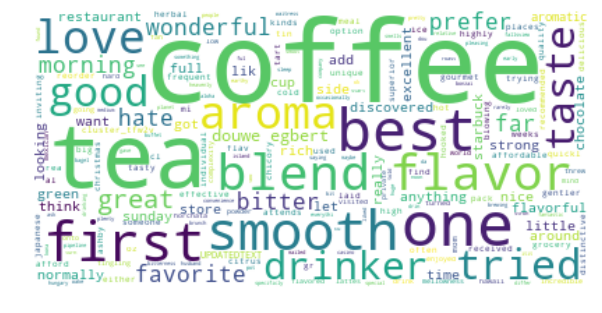

In [309]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(tw3))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [310]:
tw4=TW[TW['cluster_tfw2v']==4]
tw4.head(5)

UPDATEDTEXT  cluster_tfw2v
5906   another favorite house cat not want times mont...              4
5886   version ground not current cat favorite versio...              4
24521  used swheat least years never bug problem live...              4
17072  pug perhaps spoiled comes treats ordered chick...              4
29901  used decor ginger bread kids actually picked b...              4

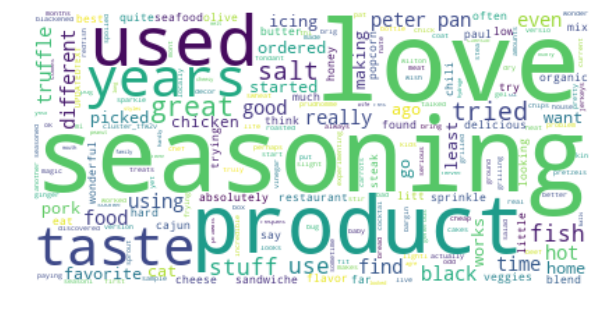

In [311]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(tw4))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# [2] Agglomerative Clustering :

## AVERAGE W2V :

In [420]:
sent_vectors_train1=sent_vectors_train[:5000]


In [521]:
from sklearn.cluster import AgglomerativeClustering
agm = AgglomerativeClustering(n_clusters=2)
agm.fit(sent_vectors_train1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [522]:
X1_train1=X1_train[:5000]

In [523]:
X1_train1['Acluster_avgw2v']=agm.labels_
ALC=pd.concat([X1_train1[['UPDATEDTEXT','Acluster_avgw2v']]])
ALC.head(5)

UPDATEDTEXT  Acluster_avgw2v
22620  dogs loves chicken product china wont buying a...                1
22621  dogs love saw pet store tag attached regarding...                1
70677  infestation fruitflies literally everywhere fl...                0
70676  worst product gotten long time would rate no s...                0
70675  wish would read reviews making purchase basica...                0

In [524]:
alc0=ALC[ALC['Acluster_avgw2v']==0]
alc0.head(5)

UPDATEDTEXT  Acluster_avgw2v
70677  infestation fruitflies literally everywhere fl...                0
70676  worst product gotten long time would rate no s...                0
70675  wish would read reviews making purchase basica...                0
70673  happy item many flies disturbing kitchen put p...                0
70672  thing item trapped fruit flies not work fly tr...                0

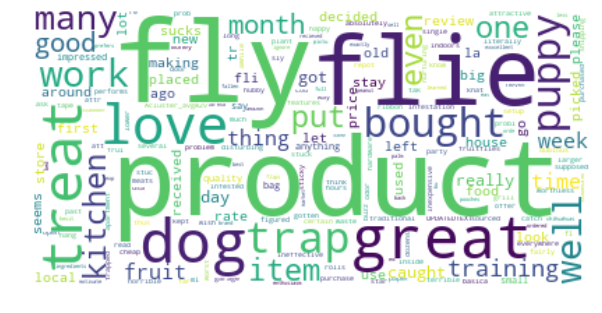

In [525]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(alc0))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [526]:
alc1=ALC[ALC['Acluster_avgw2v']==1]
alc1.head(5)

UPDATEDTEXT  Acluster_avgw2v
22620  dogs loves chicken product china wont buying a...                1
22621  dogs love saw pet store tag attached regarding...                1
2942   glad cocker standard poodle puppy loves stuff ...                1
2941   using food months find excellent fact two dogs...                1
1071   nine cats crazy kibbles last thing want cat fo...                1

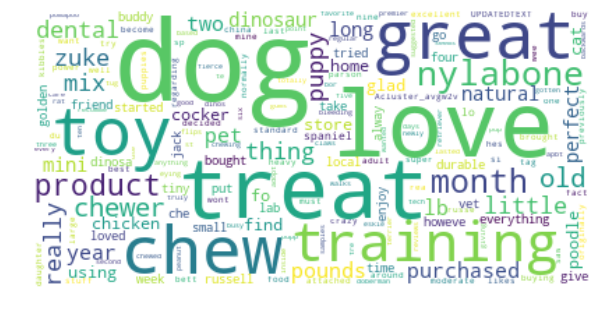

In [527]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(alc1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## TFIDF Weighted W2V :

In [530]:
tfidf_sent_vectors_train1=tfidf_sent_vectors_train[:5000]

In [531]:
X1_train1=X1_train[:5000]

In [547]:
from sklearn.cluster import AgglomerativeClustering
agm1 = AgglomerativeClustering(n_clusters=2)
agm1.fit(tfidf_sent_vectors_train1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [548]:
X1_train1['Acluster_tfw2v']=agm1.labels_
ALC1=pd.concat([X1_train1[['UPDATEDTEXT','Acluster_tfw2v']]])
ALC1.head(5)

UPDATEDTEXT  Acluster_tfw2v
22620  dogs loves chicken product china wont buying a...               1
22621  dogs love saw pet store tag attached regarding...               1
70677  infestation fruitflies literally everywhere fl...               0
70676  worst product gotten long time would rate no s...               0
70675  wish would read reviews making purchase basica...               0

In [549]:
alc10=ALC1[ALC1['Acluster_tfw2v']==0]
alc10.head(5)

UPDATEDTEXT  Acluster_tfw2v
70677  infestation fruitflies literally everywhere fl...               0
70676  worst product gotten long time would rate no s...               0
70675  wish would read reviews making purchase basica...               0
70673  happy item many flies disturbing kitchen put p...               0
70672  thing item trapped fruit flies not work fly tr...               0

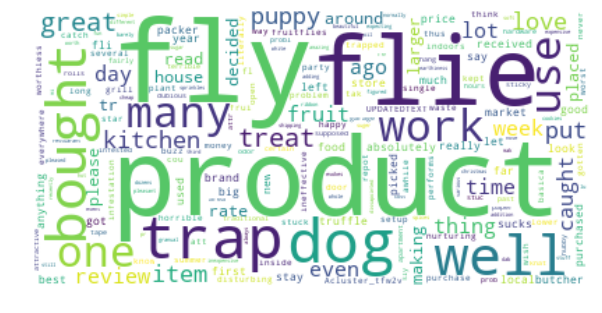

In [550]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(alc10))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [551]:
alc11=ALC1[ALC1['Acluster_tfw2v']==1]
alc11.head(5)

UPDATEDTEXT  Acluster_tfw2v
22620  dogs loves chicken product china wont buying a...               1
22621  dogs love saw pet store tag attached regarding...               1
2942   glad cocker standard poodle puppy loves stuff ...               1
2941   using food months find excellent fact two dogs...               1
1071   nine cats crazy kibbles last thing want cat fo...               1

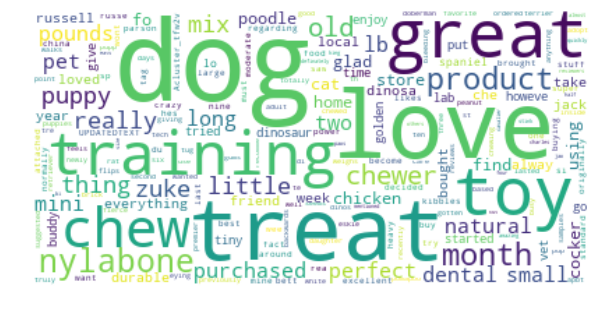

In [552]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(alc11))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# [3] DBSCAN :

## Average W2V :

In [747]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
train_data = scaler.fit_transform(sent_vectors_train1)

In [790]:
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=100,metric='euclidean')
nn.fit(train_data)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=100, p=2, radius=1.0)

In [791]:
dist,index=nn.kneighbors(train_data)
distances=dist[:,-1]

In [792]:
distances.sort()

Text(0,0.5,'Distance')

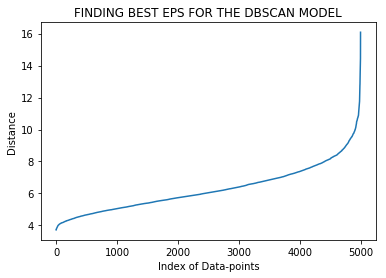

In [793]:
plt.plot(distances)
plt.title("FINDING BEST EPS FOR THE DBSCAN MODEL")
plt.xlabel("Index of Data-points")
plt.ylabel("Distance")

In [815]:
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=8,min_samples=100)
db.fit(train_data)

DBSCAN(algorithm='auto', eps=8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=None, p=None)

In [816]:
label = db.labels_

In [817]:
print('POINTS WITH LABEL',0,list(label).count(0))
print('POINTS WITH LABEL',-1,list(label).count(-1))

POINTS WITH LABEL 0 4929
POINTS WITH LABEL -1 71


In [806]:
X1_train1['clusters_dbavgw2v']=db.labels_
dbavgw2v=pd.concat([X1_train1[['UPDATEDTEXT','clusters_dbavgw2v']]])
dbavgw2v.head(10)

UPDATEDTEXT  clusters_dbavgw2v
22620  dogs loves chicken product china wont buying a...                  0
22621  dogs love saw pet store tag attached regarding...                  0
70677  infestation fruitflies literally everywhere fl...                  0
70676  worst product gotten long time would rate no s...                  0
70675  wish would read reviews making purchase basica...                  0
70673  happy item many flies disturbing kitchen put p...                  0
70672  thing item trapped fruit flies not work fly tr...                  0
70671  nurturing plant work well decided repot larger...                  0
70670  placed around house several days setup fly att...                  0
70669  please not waste money fly trap absolutely use...                  0

In [807]:
dbs1=dbavgw2v[dbavgw2v['clusters_dbavgw2v']==0]
dbs1.head(5)

UPDATEDTEXT  clusters_dbavgw2v
22620  dogs loves chicken product china wont buying a...                  0
22621  dogs love saw pet store tag attached regarding...                  0
70677  infestation fruitflies literally everywhere fl...                  0
70676  worst product gotten long time would rate no s...                  0
70675  wish would read reviews making purchase basica...                  0

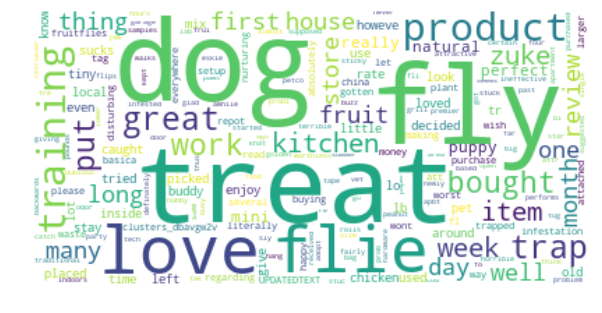

In [808]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(dbs1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [809]:
dbs2=dbavgw2v[dbavgw2v['clusters_dbavgw2v']==-1]
dbs2.head(5)

UPDATEDTEXT  clusters_dbavgw2v
5894   cat picky tried every brand flavor cat favorite                 -1
17076       dog refused eat give away beware dog picky                 -1
17122  zuke best dog loves eat zuke best dog loves eat                 -1
16173                      buy pet store web rip sorry                 -1
11465      agree review flavor favorite treats amazing                 -1

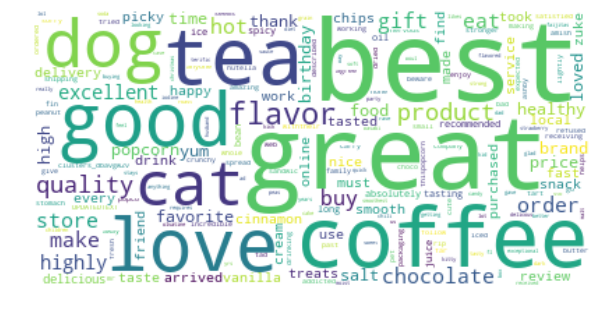

In [810]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(dbs2))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## TFIDF weighted W2V :

In [840]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
train_data1 = scaler.fit_transform(tfidf_sent_vectors_train1)

In [841]:
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=100,metric='euclidean')
nn.fit(train_data1)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=100, p=2, radius=1.0)

In [842]:
dist,index=nn.kneighbors(train_data1)
distances=dist[:,-1]

In [843]:
distances.sort()

Text(0,0.5,'Distance')

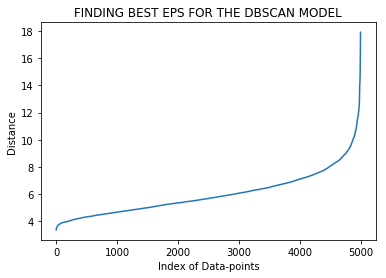

In [844]:
plt.plot(distances)
plt.title("FINDING BEST EPS FOR THE DBSCAN MODEL")
plt.xlabel("Index of Data-points")
plt.ylabel("Distance")

In [845]:
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=8,min_samples=100)
db.fit(train_data1)

DBSCAN(algorithm='auto', eps=8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=None, p=None)

In [846]:
label = db.labels_

In [847]:
print('POINTS WITH LABEL',0,list(label).count(0))
print('POINTS WITH LABEL',-1,list(label).count(-1))

POINTS WITH LABEL 0 4954
POINTS WITH LABEL -1 46


In [848]:
X1_train1['clusters_dbtfw2v']=db.labels_
dbtfw2v=pd.concat([X1_train1[['UPDATEDTEXT','clusters_dbtfw2v']]])
dbavgw2v.head(10)

UPDATEDTEXT  clusters_dbavgw2v
22620  dogs loves chicken product china wont buying a...                  0
22621  dogs love saw pet store tag attached regarding...                  0
70677  infestation fruitflies literally everywhere fl...                  0
70676  worst product gotten long time would rate no s...                  0
70675  wish would read reviews making purchase basica...                  0
70673  happy item many flies disturbing kitchen put p...                  0
70672  thing item trapped fruit flies not work fly tr...                  0
70671  nurturing plant work well decided repot larger...                  0
70670  placed around house several days setup fly att...                  0
70669  please not waste money fly trap absolutely use...                  0

In [849]:
dbs1=dbtfw2v[dbtfw2v['clusters_dbtfw2v']==0]
dbs1.head(5)

UPDATEDTEXT  clusters_dbtfw2v
22620  dogs loves chicken product china wont buying a...                 0
22621  dogs love saw pet store tag attached regarding...                 0
70677  infestation fruitflies literally everywhere fl...                 0
70676  worst product gotten long time would rate no s...                 0
70675  wish would read reviews making purchase basica...                 0

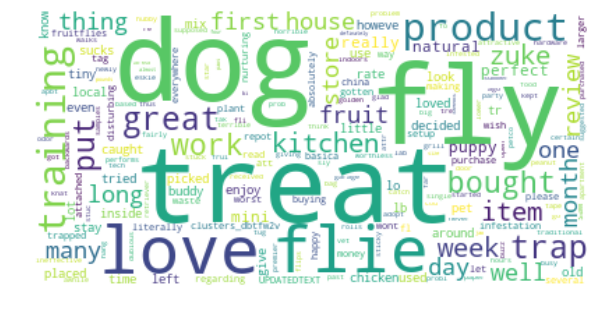

In [850]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(dbs1))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [851]:
dbs2=dbtfw2v[dbtfw2v['clusters_dbtfw2v']==-1]
dbs2.head(5)

UPDATEDTEXT  clusters_dbtfw2v
5894     cat picky tried every brand flavor cat favorite                -1
68505  sauce best low sodium sauce however shipping p...                -1
74130           great gift fast delivery quality product                -1
16085  best hot chocolate ever tasted cinnamon makes ...                -1
9651   beans good find none local stores carry dried ...                -1

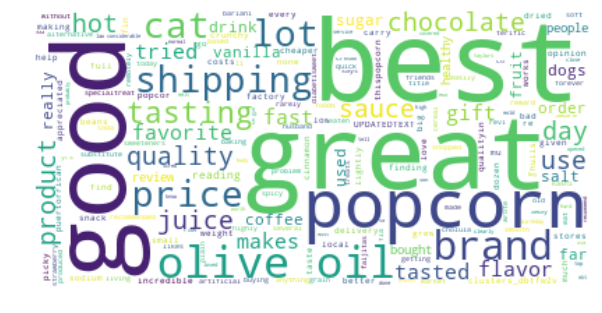

In [852]:
wordcloud = WordCloud(
                          background_color='white',
                            
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(dbs2))

print(wordcloud)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Conclusions:

In [868]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer","Methods", "Hyperparameter- Clusters","Hyperparameter - epsilon"])
x.align["Vectorizer"] = "l"
x.align["Methods"] = "l"
x.add_row(["BOW","KMEANS \n","6","-"])
x.add_row(["tfidf","KMEANS\n","6","-"])
x.add_row(["Average w2v","KMEANS \nAgglomerative\nDBSCAN\n","6\n2\n-","-\n-\n8"])
x.add_row(["Tfidf w2v","KMEANS \nAgglomerative\nDBSCAN\n","5\n2\n-","-\n-\n8"])

print(x.get_string(title="KMEANS, Agglomerative, DBSCAN ON DIFFERENT FEATURIZATION"))

+-----------------------------------------------------------------------------------+
|              KMEANS, Agglomerative, DBSCAN ON DIFFERENT FEATURIZATION             |
+-------------+---------------+--------------------------+--------------------------+
| Vectorizer  | Methods       | Hyperparameter- Clusters | Hyperparameter - epsilon |
+-------------+---------------+--------------------------+--------------------------+
| BOW         | KMEANS        |            6             |            -             |
|             |               |                          |                          |
| tfidf       | KMEANS        |            6             |            -             |
|             |               |                          |                          |
| Average w2v | KMEANS        |            6             |            -             |
|             | Agglomerative |            2             |            -             |
|             | DBSCAN        |            -          